<a href="https://colab.research.google.com/github/Passssa/Labs-of-Machine-Learning/blob/main/Lab3/Lab4(3)_Pashnina_Alyona_var16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`Дисциплина: Методы и технологии машинного обучения`   
`Уровень подготовки: бакалавриат`   
`Направление подготовки: 01.03.02 Прикладная математика и информатика`   
`Семестр: осень 2022/2023`   




# Лабораторная работа №4: Методы снижения размерности. Регуляризация логистической регрессии. 

В практических примерах ниже показано:   

* как снижать размерность пространства признаков методами главных компонент (PCR), частных наименьшах квадратов (PLS)  
* как строить логистическую регрессию с регуляризацией параметров (методы ридж и лассо) 

Точность всех моделей оценивается методом перекрёстной проверки по 10 блокам.  

*Модели*: множественная линейная регрессия 
*Данные*: `Wines` (источник: [репозиторий к книге С.Рашки Python и машинное обучение, глава 4](https://github.com/rasbt/python-machine-learning-book-3rd-edition/tree/master/ch04))

# Указания к выполнению


## Загружаем пакеты

In [73]:
# загрузка пакетов: инструменты --------------------------------------------
#  работа с массивами
import numpy as np
#  фреймы данных
import pandas as pd
#  распределение Стьюдента для проверки значимости
from scipy.stats import t
# подсчёт частот внутри массива
from collections import Counter
#  графики
import matplotlib as mpl
#  стили и шаблоны графиков на основе matplotlib
import seaborn as sns

# загрузка пакетов: данные -------------------------------------------------
from sklearn import datasets

# загрузка пакетов: модели -------------------------------------------------
#  стандартизация показателей
from sklearn.preprocessing import StandardScaler
#  метод главных компонент
from sklearn.decomposition import PCA
# метод частных наименьших квадратов
from sklearn.cross_decomposition import PLSRegression
#  логистическая регрессия (ММП)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
#  перекрёстная проверка по k блокам
from sklearn.model_selection import KFold, cross_val_score
#  расчёт Acc и сводка по точности классификации
from sklearn.metrics import accuracy_score, classification_report

In [74]:
# константы
#  ядро для генератора случайных чисел
my_seed = 9212
#  создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
#  примеры стилей и шаблонов графиков: 
#  http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
# sns.color_palette("Set2")

In [75]:
# функция, которая строит график сжатия коэффициентов в ридж и лассо
#  из репозитория к книге С.Рашки Python и машинное обучение,
#  слегка переработанная
def plot_coeffs_traces (X, y, class_number, penalty_name, C_opt, col_names,
                        C_min_pow=-4, C_max_pow=3.) :
    fig = plt.figure()
    ax = plt.subplot(111)    
    
    # палитра
    colors = sns.color_palette("Spectral", len(col_names)-1)
    
    weights, params = [], []
    for c in np.arange(C_min_pow, C_max_pow+1):
        lr = LogisticRegression(penalty=penalty_name, 
                                C=10.**c, solver='liblinear', 
                                multi_class='ovr', random_state=my_seed)
        lr.fit(X, y)
        weights.append(lr.coef_[class_number])
        params.append(10**c)

    weights = np.array(weights)

    for column, color in zip(range(weights.shape[1]), colors):
        plt.plot(params, weights[:, column],
                 label=col_names[column],
                 color=color)

    # отсечки по оптимальным C
    plt.axvline(x=C_opt[class_number], color='magenta', 
                linestyle='--', linewidth=1)

    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.xlim([10**(C_min_pow), 10**C_max_pow])
    plt.ylabel('weight coefficient')
    plt.xlabel('C')
    plt.xscale('log')
    plt.legend(loc='upper left')
    ax.legend(loc='upper center', 
              bbox_to_anchor=(1.38, 1.03),
              ncol=1, fancybox=True)
    plt.show()

## Загружаем данные

Набор данных `wine` можно загрузить напрямую из пакета `sklearn` (набор впервые выложен [на сайте Калифорнийского университета в Ирвине](http://archive.ics.uci.edu/ml/datasets/Wine)). Таблица содержит результаты химического анализа вин, выращенных в одном регионе Италии тремя разными производителями. Большинство столбцов таблицы отражают содержание в вине различных веществ:   

* `alcohol` – алкоголь, процентное содержание;  
* `malic_acid` – яблочная кислота (разновидность кислоты с сильной кислотностью и ароматом яблока);  
* `ash` – зола (неорганическая соль, оказывающая влияние на вкус и придающая вину ощущение свежести);  
* `alcalinity_of_ash` – щелочность золы;  
* `magnesium` – магний (важный для организма слабощелочной элемент, способствующий энергетическому обмену);  
* `total_phenols` – всего фенола (молекулы, содержащие полифенольные вещества; имеют горький вкус, также влияют на цвет, относятся к питательным веществам в вине);  
* `flavanoids` – флаваноиды (полезный антиоксидант, даёт богатый аромат и горький вкус);  
* `nonflavanoid_phenols` – фенолы нефлаваноидные (специальный ароматический газ, устойчивый к окислению);  
* `proanthocyanins` – проантоцианы (биофлавоноидное соединение, которое также является природным антиоксидантом с легким горьковатым запахом); 
* `color_intensity` – интенсивность цвета; 
* `hue` – оттенок (мера яркости цвета, используется в т.ч. для измерения возраста вина); 
* `od280/od315_of_diluted_wines` – OD280/OD315 разбавленных вин (метод определения концентрации белка); 
* `proline` – пролин (основная аминокислота в красном вине, важный фактор вкуса и аромата); 
* `target` – целевая переменная: класс вина.   

Загружаем данные во фрейм и выясняем их размерность.  

In [76]:
# загружаем таблицу и превращаем её во фрейм
DF_all = pd.read_csv('https://raw.githubusercontent.com/ania607/ML/main/data/default_of_credit_card_clients.csv')

# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_all.shape)

Число строк и столбцов в наборе данных:
 (30000, 24)


Отложим 10% наблюдений для прогноза.  

In [77]:
DF_all = DF_all.drop(['PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',\
                      'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],axis = 1)

In [78]:
# наблюдения для моделирования
DF = DF_all.sample(frac=0.85, random_state=my_seed)
# отложенные наблюдения
DF_predict = DF_all.drop(DF.index)

In [79]:
# первые 5 строк фрейма у первых 7 столбцов
DF.iloc[:, :7].head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2
23739,80000,2,2,2,51,0,0
2303,180000,1,2,2,32,1,2
8847,200000,1,1,2,33,-1,-1
6634,10000,2,2,2,37,-1,0
17316,50000,2,3,2,39,2,2


In [80]:
# первые 5 строк фрейма у столбцов 8-11
DF.iloc[:, 7:11].head(5)

,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3
23739,0,80106,43289,21017
2303,2,172842,177065,163930
8847,-2,3557,-60,-60
6634,0,7841,7400,6770
17316,0,20039,19369,16586


In [81]:
# первые 5 строк фрейма у столбцов 12-14
DF.iloc[:, 11:].head(5)

,PAY_AMT1,PAY_AMT2,PAY_AMT3,Y
23739,1400,1500,1000,1
2303,8500,0,7000,1
8847,0,0,1800,0
6634,1157,1000,103,0
17316,0,1280,2390,1


In [82]:
# типы столбцов фрейма
DF.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
Y            int64
dtype: object

Проверим, нет ли в таблице пропусков.  

In [83]:
# считаем пропуски в каждом столбце
DF.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
Y            0
dtype: int64

Пропусков не обнаружено.  

In [84]:
DF.count()

LIMIT_BAL    25500
SEX          25500
EDUCATION    25500
MARRIAGE     25500
AGE          25500
PAY_0        25500
PAY_2        25500
PAY_3        25500
BILL_AMT1    25500
BILL_AMT2    25500
BILL_AMT3    25500
PAY_AMT1     25500
PAY_AMT2     25500
PAY_AMT3     25500
Y            25500
dtype: int64

И количество записей в нашей таблице одинаковое


# Предварительный анализ данных  

## Описательные статистики  

Считаем доли классов целевой переменной `target`.  

In [85]:
# метки классов
DF.Y.unique()

array([1, 0])

In [86]:
# доли классов
np.around(DF.Y.value_counts() / len(DF.index), 3)

0    0.778
1    0.222
Name: Y, dtype: float64

Все объясняющие переменные набора данных непрерывные. Рассчитаем для них описательные статистики.  

In [87]:
# описательные статистики
DF.iloc[:, :6].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000
mean,167239.595294,1.602157,1.855529,1.552078,35.507804,-0.018784
std,129645.337798,0.489462,0.792227,0.522142,9.211413,1.118459
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000


In [88]:
# описательные статистики
DF.iloc[:, 6:11].describe()

,PAY_2,PAY_3,BILL_AMT1,BILL_AMT2,BILL_AMT3
count,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000
mean,-0.137490,-0.171020,51168.967686,49108.259961,46937.951020
std,1.193239,1.190034,73363.717933,71082.158481,68694.470599
min,-2.000000,-2.000000,-165580.000000,-69777.000000,-157264.000000
25%,-1.000000,-1.000000,3508.250000,2936.750000,2688.000000
50%,0.000000,0.000000,22288.000000,21052.500000,20050.000000
75%,0.000000,0.000000,67384.000000,64129.750000,60164.750000
max,8.000000,8.000000,964511.000000,983931.000000,855086.000000


In [89]:
# описательные статистики
DF.iloc[:, 11:13].describe()

,PAY_AMT1,PAY_AMT2
count,25500.000000,2.550000e+04
mean,5600.972510,5.943238e+03
std,16425.394315,2.181456e+04
min,0.000000,0.000000e+00
25%,1000.000000,8.345000e+02
50%,2106.000000,2.010000e+03
75%,5007.000000,5.000000e+03
max,873552.000000,1.227082e+06


Выводы по описательным статистикам: значения объясняющих переменных положительные, масштабы измерения отличаются. Для работы с методами снижения размерности и регуляризации понадобится стандартизация значений.   

## Визуализация разброса переменных внутри классов  

Поскольку в наборе данных 13 объясняющих переменных, и все они непрерывные, анализ матричного графика разброса будет затруднительным. Построим коробчатые диаграммы для объясняющих переменных, чтобы сравнить средние уровни и разброс по классам.  

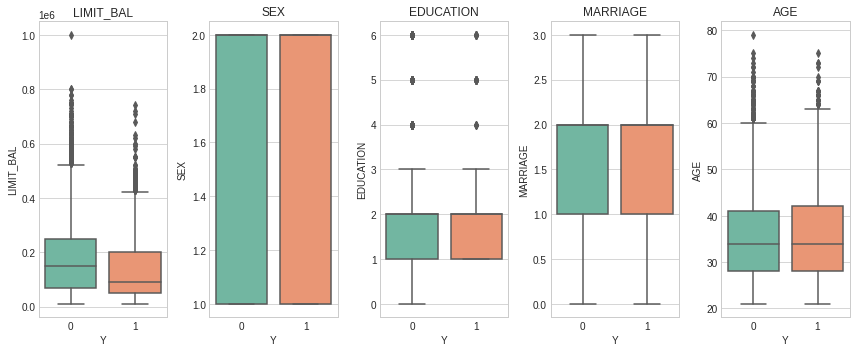

In [90]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[:5].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

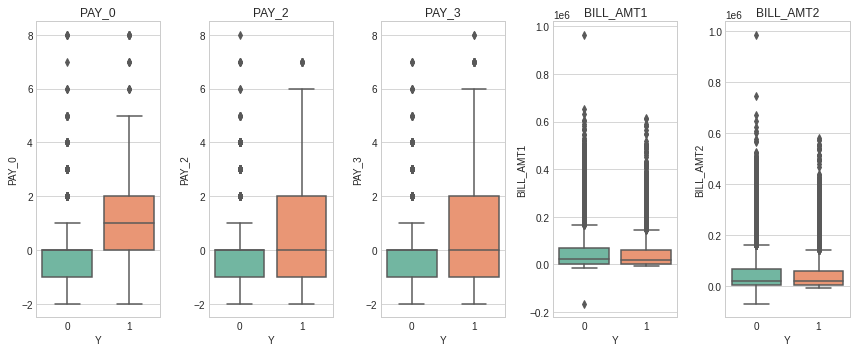

In [91]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(12, 5))
gs = mpl.gridspec.GridSpec(1, 5)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])
ax4 = plt.subplot(gs[0, 3])
ax5 = plt.subplot(gs[0, 4])

axs = [ax1, ax2, ax3, ax4, ax5]

cols_loop = list(DF.columns[5:10].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

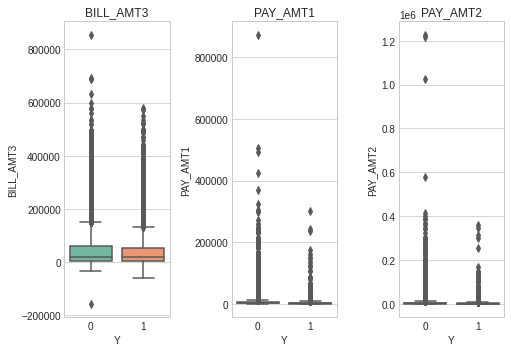

In [92]:
# создаём полотно и делим его на четыре части
fig = plt.figure(figsize=(7.2, 5))
gs = mpl.gridspec.GridSpec(1, 3)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])
ax3 = plt.subplot(gs[0, 2])

axs = [ax1, ax2, ax3]

cols_loop = list(DF.columns[10:13].values)
for col_name in cols_loop :
    i = cols_loop.index(col_name)
    sns.boxplot(x='Y', y=col_name, data=DF, ax=axs[i])
    axs[i].set_ylabel(col_name)
    axs[i].set_title(col_name)

# корректируем расположение графиков на полотне
gs.tight_layout(plt.gcf())
plt.show()

На графиках отличие в медианах и разбросе между классами прослеживается практически по всем объясняющим переменным. Меньше всего различаются коробчатые диаграммы по переменной `BILL_AMT_1`. Это говорит о том, классы по зависимой переменной `Y` неплохо разделяются по всем объясняющим переменным.  

## Корреляционный анализ   

Теперь посмотрим на взаимодействие объясняющих переменных.  

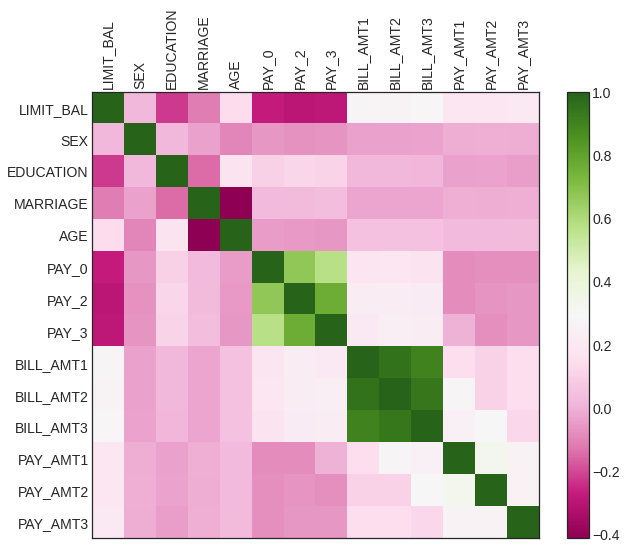

In [93]:
# рассчитываем корреляционную матрицу
corr_mat = DF.drop('Y', axis=1).corr()
col_names = DF.drop('Y', axis=1).columns

# переключаем стиль оформления, чтобы убрать сетку с тепловой карты
mpl.style.use('seaborn-white')

# рисуем корреляционную матрицу
f = plt.figure(figsize=(10, 8))
plt.matshow(corr_mat, fignum=f.number, cmap='PiYG')
# координаты для названий строк и столбцов
tics_coords = np.arange(0, len(col_names))
# рисуем подписи
plt.xticks(tics_coords, col_names, fontsize=14, rotation=90)
plt.yticks(tics_coords, col_names, fontsize=14)
# настраиваем легенду справа от тепловой карты
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

Между объясняющими переменными обнаруживаются как прямые, так и обратные линейные взаимосвязи. Выведем все значимые коэффициенты в одной таблице и определим минимальный / максимальный из них.     

In [94]:
# делаем фрейм из корреляционной матрицы и стираем диагональные значения
#  и нижний треугольник матрицы
df = corr_mat
df = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))
# меняем размерность с матрицы на таблицу: показатель 1, показатель 2,
#  корреляция
df = df.stack().reset_index()
df.columns = ['Показатель_1', 'Показатель_2', 'Корреляция']
# считаем двусторонние p-значения для проверки значимости
t_stat = np.sqrt((len(DF.index) - 2) / (1 - df.Корреляция ** 2))
df['P_значение'] = 2 * (1 - t.cdf(abs(t_stat), len(DF.index) - 2))
# получили все корреляционные коэффициенты без 1 и без повторов
#  выводим все значимые с сортировкой
df.loc[df['P_значение'] < 0.05].sort_values('Корреляция')

,Показатель_1,Показатель_2,Корреляция,P_значение
36,MARRIAGE,AGE,-0.412241,0.0
5,LIMIT_BAL,PAY_2,-0.296381,0.0
6,LIMIT_BAL,PAY_3,-0.286798,0.0
4,LIMIT_BAL,PAY_0,-0.273720,0.0
1,LIMIT_BAL,EDUCATION,-0.220573,0.0
...,...,...,...,...
55,PAY_0,PAY_2,0.669282,0.0
63,PAY_2,PAY_3,0.765385,0.0
77,BILL_AMT1,BILL_AMT3,0.900991,0.0
81,BILL_AMT2,BILL_AMT3,0.935503,0.0


# Методы снижения резмерности  

Посмотрим, как работают методы снижения размерности:  

* регрессия на главные компоненты (PCR)   
* частный метод наименьших квадратов (PLS)  

Оба метода требуют предварительной стандартизации переменных.  

In [95]:
# стандартизация
sc = StandardScaler()
X_train_std = sc.fit_transform(DF.iloc[:, :13].values)

# проверяем средние и стандартные отклонения после стандартизации
for i_col in range(X_train_std.shape[1]) :
    print('Столбец ', i_col, ': среднее = ',
          np.round(np.mean(X_train_std[:, i_col]), 2),
         '   Станд. отклонение = ', 
          np.round(np.std(X_train_std[:, i_col]), 2), sep='')

Столбец 0: среднее = 0.0   Станд. отклонение = 1.0
Столбец 1: среднее = 0.0   Станд. отклонение = 1.0
Столбец 2: среднее = 0.0   Станд. отклонение = 1.0
Столбец 3: среднее = -0.0   Станд. отклонение = 1.0
Столбец 4: среднее = -0.0   Станд. отклонение = 1.0
Столбец 5: среднее = -0.0   Станд. отклонение = 1.0
Столбец 6: среднее = 0.0   Станд. отклонение = 1.0
Столбец 7: среднее = 0.0   Станд. отклонение = 1.0
Столбец 8: среднее = -0.0   Станд. отклонение = 1.0
Столбец 9: среднее = -0.0   Станд. отклонение = 1.0
Столбец 10: среднее = 0.0   Станд. отклонение = 1.0
Столбец 11: среднее = -0.0   Станд. отклонение = 1.0
Столбец 12: среднее = 0.0   Станд. отклонение = 1.0


## Метод частных наименьших квадратов   (Метод снижения размерности, соответствующий моему варианту)
Сначала посмотрим, как работает метод на всех наблюдениях обучающего набора.  

In [96]:
# функция для оценки модели, берём все компоненты, по числу столбцов X
pls = PLSRegression(n_components=13)
# значения зависимой переменной превращаем в фиктивные по классам
Y_train = pd.get_dummies(DF.Y.astype(str))
# оцениваем
pls.fit(X_train_std, Y_train)

# считаем долю объяснённой дисперсии
frac_var_expl = np.var(pls.x_scores_, axis=0) / np.sum(np.var(X_train_std, axis=0))
print('Доли объяснённой дисперсии по компонентам в PLS:\n',
     np.around(frac_var_expl, 3),
     '\nОбщая сумма долей:', np.around(sum(frac_var_expl), 3))

Доли объяснённой дисперсии по компонентам в PLS:
 [0.19  0.109 0.119 0.059 0.073 0.017 0.042 0.023 0.029 0.042 0.008 0.026
 0.041] 
Общая сумма долей: 0.778


Из-за того, что при вычислении компонент метдом PLS мы учитываем корреляцию с $Y$, компоненты, во-первых, не ортогональны, а во-вторых сумма объяснённых долей дисперсии уже не равняется 1.  

In [97]:
# сокращаем пространство компонент до 2
pls = PLSRegression(n_components=2)
# перестраиваем модель
pls.fit(X_train_std, Y_train)
# пересчитываем X
X_train_pls = pls.transform(X_train_std)
# предсказываем принадлежности классов для обучающего набора
Y_train_pred = pls.predict(X_train_std)
pd.DataFrame(Y_train_pred)

,0,1
0,0.745899,0.254101
1,0.662959,0.337041
2,0.888142,0.111858
3,0.788571,0.211429
4,0.539898,0.460102
...,...,...
25495,0.743367,0.256633
25496,0.986125,0.013875
25497,0.798656,0.201344
25498,0.780696,0.219304


In [98]:
# вычисляем классы
Y_train_hat = list()
for y_i in Y_train_pred : 
    Y_train_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
# Y_train_hat
# сколько наблюдений попали в каждый класс по модели
Counter(Y_train_hat).items()

dict_items([(0, 24348), (1, 1152)])

Рисуем классы на графике в координатах 2 главных компонент по PLS.  

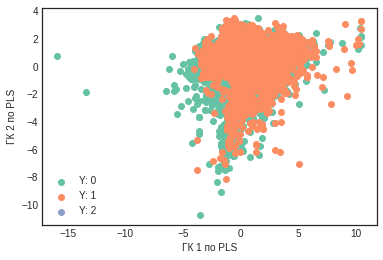

In [99]:
# график классов в пространстве ГК
plt.scatter(X_train_pls[DF['Y'] == 0][:, 0], 
            X_train_pls[DF['Y'] == 0][:, 1], label='Y: 0')
plt.scatter(X_train_pls[DF['Y'] == 1][:, 0], 
            X_train_pls[DF['Y'] == 1][:, 1], label='Y: 1')
plt.scatter(X_train_pls[DF['Y'] == 2][:, 0], 
            X_train_pls[DF['Y'] == 2][:, 1], label='Y: 2')
plt.xlabel('ГК 1 по PLS')
plt.ylabel('ГК 2 по PLS')
plt.legend()
plt.show()

Видно, что в координатах двух компонент, рассчитанных методом частных наименьших квадратов, классы также оказываются очень плохо разделимы.  
Теперь оценим точность модели с перекрёстной проверкой.  

In [100]:
# функция разбиения на блоки для перекрёстной проверки
#  для чистоты эксперимента возьмём другое ядро генератора случайных чисел
kf_10 = KFold(n_splits=10, random_state=my_seed+1, shuffle=True)
# считаем точность модели (Acc) с перекрёстной проверкой по блокам
#  функция cross_val_score не сработает, т.к. у нас мультиклассовая
#  классификация, поэтому делаем вручную
# значения Y как метки классов
Y_train = DF.Y.values
# значения Y как фиктивные переменные
Y_train_dummy = pd.get_dummies(Y_train.astype(str))
# модель внутри блока
pls_cv = PLSRegression(n_components=2)
# для записи Acc по блокам
acc_blocks = list()
# цикл по блокам
score = list()

for train_index, test_index in kf_10.split(X_train_std, DF.Y.values) : 
    # данные для модели внутри блока
    X_i_train = X_train_std[train_index]
    Y_i_train = Y_train_dummy.iloc[train_index, :]

    # данные для прогноза вне блока
    X_i_test = X_train_std[test_index]
    Y_i_test = Y_train[test_index]

    # оцениваем модель на блоке
    pls_cv.fit(X_i_train, Y_i_train)
    # делаем прогноз y вне блока
    Y_pred = pls.predict(X_i_test)
    Y_hat = list()
    for y_i in Y_pred : 
        Y_hat.append([i for i in range(len(y_i)) if y_i[i] == max(y_i)][0])
    # считаем точность
    acc = accuracy_score(Y_i_test, Y_hat)
    acc_blocks.append(acc)

score_models = list()
score.append(np.around(np.mean(acc_blocks), 3))
score_models.append('logit_PLS')
print('Модель ', score_models[0], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', np.around(score[0], 2), sep='')

Модель logit_PLS, перекрёстная проверка по 10 блокам
Acc = 0.8


# Методы сжатия  


## Лассо-регрессия

Технически реализация лассо-регрессии отличается от ридж единственным аргументом `penalty='l1'` в функции `LogisticRegression`.    

In [101]:
# функция для построения модели
logit_lasso = LogisticRegression(penalty='l1', solver='liblinear')
# оцениваем параметры
logit_lasso.fit(X_train_std, Y_train)
# выводим параметры
print('Константы моделей для классов:\n', np.around(logit_lasso.intercept_, 3),
     '\nКоэффициенты моделей для классов:\n', np.around(logit_lasso.coef_, 3))

Константы моделей для классов:
 [-1.454] 
Коэффициенты моделей для классов:
 [[-0.13  -0.047 -0.082 -0.073  0.072  0.667  0.106  0.123 -0.449  0.179
   0.164 -0.249 -0.216]]


Отметим, что в векторе коэффициентов появились ненулевые, но близкие к нулю значения: метод лассо позволяет обнулять коэффициенты, тем самым отбрасывая слабые объясняющие переменные.  

In [102]:
# поиск оптимального значения C:
#  подбираем C по наибольшей точности с перекрёстной проверкой
lasso_cv = LogisticRegressionCV(cv=10, random_state=my_seed+3,
                               penalty='l1', solver='liblinear')
lasso_cv.fit(X_train_std, Y_train)
# значения параметра C (инверсия лямбды), которые дают наилучшую
#  точность для каждого класса
lasso_cv.C_

array([0.35938137])

In [104]:
# сохраняем и выводим Acc для модели
score.append(np.around(lasso_cv.score(X_train_std, Y_train), 3))
score_models.append('logit_lasso')
print('Модель ', score_models[1], ', перекрёстная проверка по 10 блокам',
      '\nAcc = ', score[1], sep='')

Модель logit_lasso, перекрёстная проверка по 10 блокам
Acc = 0.81


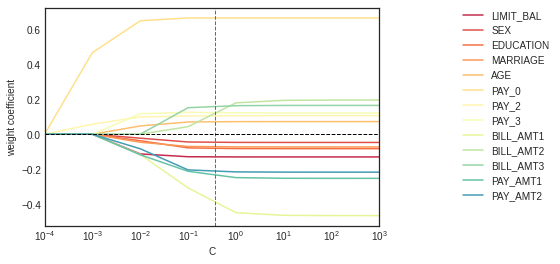

In [105]:
# график динамики коэффициентов в лассо-регрессии    
#  модель для класса 0
plot_coeffs_traces(X_train_std, Y_train, 0, 'l1', lasso_cv.C_, DF.columns)

Итак, судя по графикам, для значения гиперпараметра, дающего самую точную модель, ни один коэффициент при объясняющих переменных не обнуляется.


# Прогноз на отложенные наблюдения по лучшей модели

Ещё раз посмотрим на точность построенных моделей.  

In [108]:
# сводка по точности моделей
pd.DataFrame({'Модель' : score_models, 'Acc' : score})


,Модель,Acc
0,logit_PLS,0.796
1,logit_lasso,0.810
2,logit_lasso,0.810


Все модели показывают высокую точность по показателю $Acc$, при этом самой точной оказывается лассо-регрессия. Сделаем прогноз на отложенные наблюдения.   

In [110]:
# формируем объекты с данными отложенной выборки
X_pred_std = sc.fit_transform(DF_predict.iloc[:, :13].values)
Y_pred = DF_predict.Y
Y_hat = logit_lasso.predict(X_pred_std)
# отчёт по точности на отложенных наблюдениях
print(classification_report(Y_pred, Y_hat))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      3535
           1       0.70      0.24      0.36       965

    accuracy                           0.82      4500
   macro avg       0.76      0.61      0.62      4500
weighted avg       0.80      0.82      0.78      4500



Итак, методом логистической регрессии со сжатием коэффициенты с L1-регуляризацией мы получили идеально точную скоринговую модель по выдаче кредита.  

# Источники 

1. *Рашка С.* Python и машинное обучение: крайне необходимое пособие по новейшей предсказательной аналитике, обязательное для более глубокого понимания методологии машинного обучения / пер. с англ. А.В. Логунова. – М.: ДМК Пресс, 2017. – 418 с.: ил.  
1. Репозиторий с кодом к книге *Рашка С.* Python и машинное обучение / github.com. URL: <https://github.com/rasbt/python-machine-learning-book-3rd-edition>  
1. *Xueting Bai*, *Lingbo Wang*, *Hanning Li* Identification of red wine categories based on physicochemical properties / 2019 5th International Conference on Education Technology, Management and Humanities Science (ETMHS 2019). URL: <https://webofproceedings.org/proceedings_series/ESSP/ETMHS%202019/ETMHS19309.pdf>  

